##Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classifiaction models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too). 
<br><br>
The set up and approach will not be too dissimilar to the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.  
<br>
Feel free to adapt this exercise to play with other datasets readily availabe in the Databricks enviornment (they are listed in a cell below). 
#####Getting Started
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with: 
- Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)
- Python Version 3

#####Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)

####Get Data

Here we will pull in some sample data that is already pre-loaded onto all databricks clusters.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

In [3]:
# display datasets already in databricks
#display(dbutils.fs.ls("/databricks-datasets")).show(5)

Lets take a look at the '**adult**' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. [Here](https://archive.ics.uci.edu/ml/datasets/adult) is the same data in the UCI repository.

_As an aside: [here](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census) this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here)._

In [5]:
%fs ls databricks-datasets/adult/adult.data

path,name,size
dbfs:/databricks-datasets/adult/adult.data,adult.data,3974305


**Note**: Above  %fs is just some file system cell magic that is specific to databricks. More info [here](https://docs.databricks.com/user-guide/notebooks/index.html#mix-languages).

####Spark SQL
Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called _adult_ and a Spark Dataframe called _df_adult_. 
<br><br>
This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [8]:
%sql 
-- drop the table if it already exists
DROP TABLE IF EXISTS adult

In [9]:
%sql
-- create a new table in Spark SQL from the datasets already loaded in the underlying filesystem.
-- In the real world you might be pointing at a file on HDFS or a hive table etc. 
CREATE TABLE adult (
  age DOUBLE,
  workclass STRING,
  fnlwgt DOUBLE,
  education STRING,
  education_num DOUBLE,
  marital_status STRING,
  occupation STRING,
  relationship STRING,
  race STRING,
  sex STRING,
  capital_gain DOUBLE,
  capital_loss DOUBLE,
  hours_per_week DOUBLE,
  native_country STRING,
  income STRING)
USING com.databricks.spark.csv
OPTIONS (path "/databricks-datasets/adult/adult.data", header "true")

In [10]:
# look at the data
#spark.sql("SELECT * FROM adult LIMIT 5").show() 
# this will look prettier in Databricks if you use display() instead
display(spark.sql("SELECT * FROM adult LIMIT 5"))

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K


In [11]:
%sql

SELECT * FROM adult limit 5

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K


If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.

In [13]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  LIMIT 5
  """)
display(result)

occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
Prof-specialty,4140,0.53,0.02,0.13,0.02,0.3
Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
Exec-managerial,4066,0.61,0.02,0.15,0.02,0.2
Adm-clerical,3769,0.28,0.04,0.22,0.04,0.42
Sales,3650,0.47,0.03,0.12,0.03,0.36


You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.

In [15]:
# register the df we just made as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
df = spark.sql("SELECT * FROM result")
display(df.head(5))

occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
Prof-specialty,4140,0.53,0.02,0.13,0.02,0.3
Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
Exec-managerial,4066,0.61,0.02,0.15,0.02,0.2
Adm-clerical,3769,0.28,0.04,0.22,0.04,0.42
Sales,3650,0.47,0.03,0.12,0.03,0.36


In [16]:
############ QUESTION ############################

####<span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [18]:
### Question 1.1 Answer ###
result = spark.sql(
  """
  SELECT 
    education,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY bachelor_rate DESC
  """)
sqlContext.registerDataFrameAsTable(result, "edu_summary")
display(spark.sql("SELECT education FROM edu_summary ORDER BY bachelor_rate DESC LIMIT 1"))

#result.show()

education
12th


####Spark DataFrames
Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [20]:
# register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now

In [21]:
# look at df schema
df_adult.printSchema()
#df_adult.show()

root
-- age: double (nullable = true)
-- workclass: string (nullable = true)
-- fnlwgt: double (nullable = true)
-- education: string (nullable = true)
-- education_num: double (nullable = true)
-- marital_status: string (nullable = true)
-- occupation: string (nullable = true)
-- relationship: string (nullable = true)
-- race: string (nullable = true)
-- sex: string (nullable = true)
-- capital_gain: double (nullable = true)
-- capital_loss: double (nullable = true)
-- hours_per_week: double (nullable = true)
-- native_country: string (nullable = true)
-- income: string (nullable = true)

In [22]:
# look at the df
display(df_adult.head(2))
#df_adult.show(5)

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


Below we will do a similar calculation to what we did above but using the DataFrames API

In [24]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
 occupation|divorced_rate|
+----------------+-------------+
 Adm-clerical| 0.22|
 Priv-house-serv| 0.19|
 Other-service| 0.15|
 Tech-support| 0.15|
 Exec-managerial| 0.15|
+----------------+-------------+
only showing top 5 rows

As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

In [26]:
############ QUESTION ############################

####<span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [28]:
### Question 2.1 Answer ###

from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['education'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Never-married', 1 ).otherwise(0).alias('is_notmarried')
)
# do grouping (and a round)
df_result = df_result.groupBy('education').agg(round(mean('is_notmarried'),2).alias('bachelor_rate'))
# do ordering
df_result = df_result.orderBy(desc('bachelor_rate'))
# show results
#spark.sql("select * from adult where marital_status = ' Never-married'").show()
df_result.show(1)





# wrangle the data a bit
# df_result = # fill in here
# df_result.show(1)

+---------+-------------+
education|bachelor_rate|
+---------+-------------+
 12th| 0.54|
+---------+-------------+
only showing top 1 row

####Explore & Visualize Data
It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.

In [30]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head(3))

occupation plus_50k
0 Exec-managerial 0.484014
1 Prof-specialty 0.449034
2 Protective-serv 0.325116

In [31]:
print(df_pandas.describe())

plus_50k
count 15.000000
mean 0.197357
std 0.143993
min 0.006711
25% 0.107373
50% 0.134518
75% 0.287136
max 0.484014

In [32]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
occupation 15 non-null object
plus_50k 15 non-null float64
dtypes: float64(1), object(1)
memory usage: 320.0+ bytes
None

Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want).

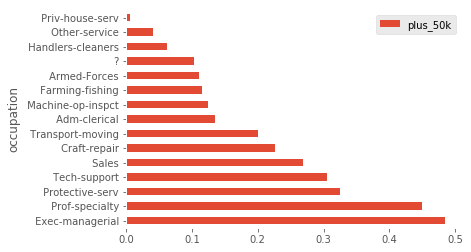

In [34]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [36]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+------------------+
summary| age| education_num|
+-------+------------------+------------------+
 count| 32560| 32560|
 mean|38.581633906633904| 10.08058968058968|
 stddev|13.640641827464002|2.5727089681052058|
 min| 17.0| 1.0|
 max| 90.0| 16.0|
+-------+------------------+------------------+

### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
### Note that OneHoteEncoderEstimator only works with Spark version 2.4.5 or lower

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [39]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [40]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [41]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
display(dataset.head(2))

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0.0,"List(0, 100, List(1, 10, 23, 31, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 83311.0, 13.0, 13.0))",50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
0.0,"List(0, 100, List(0, 8, 25, 38, 44, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 38.0, 215646.0, 9.0, 40.0))",38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


In [42]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22837
9723

In [43]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.23934842580023646

####Logistic Regression - Train

In [45]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.3334162417235758

####GBM - Train

In [47]:
################ QUESTION ########################

####<span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [49]:
### Question 3.1 Answer ###
from pyspark.ml.classification import GBTClassifier
# Create initial LogisticRegression model
gb = GBTClassifier(labelCol = "label", featuresCol  = "features", maxIter = 15) # fill in here

# Train model with Training Data
gbModel = gb.fit(trainingData) # fill in here

####Logistic Regression - Predict

In [51]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
lrPredictions.select("label", "prediction", "probability").show()
#display(lrPredictions)

+-----+----------+--------------------+
label|prediction| probability|
+-----+----------+--------------------+
 0.0| 1.0|[0.69126409891864...|
 0.0| 1.0|[0.62137348651550...|
 0.0| 1.0|[0.65862879486004...|
 0.0| 1.0|[0.65899585102898...|
 0.0| 1.0|[0.61577049345467...|
 0.0| 1.0|[0.54468707797066...|
 0.0| 1.0|[0.60484735087055...|
 0.0| 1.0|[0.59444809510805...|
 0.0| 1.0|[0.58750906903752...|
 0.0| 1.0|[0.59807927918271...|
 0.0| 0.0|[0.83647415983923...|
 0.0| 0.0|[0.98869457508731...|
 0.0| 1.0|[0.42124172564821...|
 0.0| 1.0|[0.72441603933473...|
 0.0| 1.0|[0.68494752433712...|
 0.0| 1.0|[0.75655548175983...|
 0.0| 1.0|[0.65635941640995...|
 0.0| 1.0|[0.55960948138318...|
 0.0| 1.0|[0.55066613531701...|
 0.0| 1.0|[0.51401977115676...|
+-----+----------+--------------------+
only showing top 20 rows

###GBM - Predict

In [53]:
#################### QUESTION ##########################

####<span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [55]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)# fill in here

display(gbPredictions.head(5))

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 26.0, 58426.0, 9.0, 50.0))",26.0,Private,58426.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"List(1, 2, List(), List(0.7032943887331882, -0.7032943887331882))","List(1, 2, List(), List(0.8032273467120226, 0.19677265328797744))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 83253.0, 9.0, 55.0))",30.0,Private,83253.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,55.0,United-States,<=50K,"List(1, 2, List(), List(0.5287982205137671, -0.5287982205137671))","List(1, 2, List(), List(0.742230954192389, 0.25776904580761095))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.0, 62374.0, 9.0, 50.0))",31.0,Private,62374.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"List(1, 2, List(), List(0.5287982205137671, -0.5287982205137671))","List(1, 2, List(), List(0.742230954192389, 0.25776904580761095))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 32732.0, 9.0, 50.0))",32.0,Private,32732.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"List(1, 2, List(), List(0.47715165667554305, -0.47715165667554305))","List(1, 2, List(), List(0.7219797850681451, 0.2780202149318549))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 181705.0, 9.0, 45.0))",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"List(1, 2, List(), List(0.06774461762368839, -0.06774461762368839))","List(1, 2, List(), List(0.533820586653868, 0.466179413346132))",0.0


####Logistic Regression - Evaluate

In [57]:
#################### QUESTION ##########################

####<span style="color:darkblue">Question 5</span>
1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [59]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###
  
  # F1
  print("F1 = {}".format(multi_metrics.fMeasure()))
  # Precision
  print("Precision = {}".format(multi_metrics.precision()))
  # Recall
  print("Recall = {}".format(multi_metrics.recall()))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate(0.0)))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate(0.0)))
  
print_performance_metrics(lrPredictions)

auc = 0.9032867661805299
aupr = 0.7627830907418989
Area under PR = 0.5366100314564946
Area under ROC = 0.8159794860040686
Accuracy = 0.80067880283863
DenseMatrix([[5776., 1572.],
 [ 366., 2009.]])
F1 = 0.80067880283863
Precision = 0.80067880283863
Recall = 0.80067880283863
FPR = 0.15410526315789475
TPR = 0.7860642351660315

####GBM - Evaluate

In [61]:
print_performance_metrics(gbPredictions)

auc = 0.9064732257972105
aupr = 0.7784374052792014
Area under PR = 0.6543134857014391
Area under ROC = 0.7598482365412714
Accuracy = 0.8532345983749872
DenseMatrix([[6925., 423.],
 [1004., 1371.]])
F1 = 0.8532345983749872
Precision = 0.8532345983749872
Recall = 0.8532345983749872
FPR = 0.42273684210526313
TPR = 0.9424333151878062

## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [64]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal with 1 for binomial regression, or the number oflasses for multinomial regression. (undefined)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
regParam: regularization parameter (>= 0). (default: 0.0)
standardization: whether to standardize the training features before fitting the model. (default: True)
threshold: Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p]. (default: 0.5, current: 0.23934842580023646)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold. (undefined)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 1e-06)
upperBoundsOnCoefficients: The upper bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
upperBoundsOnIntercepts: The upper bounds on intercepts if fitting under bound constrained optimization. The bound vector size must be equal with 1 for binomial regression, or the number of classes for multinomial regression. (undefined)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

In [65]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: all)
featuresCol: features column name. (default: features, current: features)
labelCol: label column name. (default: label, current: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxIter: max number of iterations (>= 0). (default: 20, current: 15)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 3504127614838123891)
stepSize: Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator. (default: 0.1)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)

####Logisitic Regression - Param Grid

In [67]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

####GBM - Param Grid

In [69]:
#################### QUESTION ##########################

####<span style="color:darkblue">Question 6</span>
1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [71]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build()) # fill in here

####Logistic Regression - Perform Cross Validation

In [73]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [74]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5

####GBM - Perform Cross Validation

In [76]:
############## QUESTION ########################

####<span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [78]:
### Question 7.1 Answer ###

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2) # fill in here

# Run cross validations
gbCvModel = gbCv.fit(trainingData) # fill in here

In [79]:
### Question 7.2 Answer ###

# look at best params from the CV
print(gbCvModel.bestModel._java_obj.getMaxDepth())
print(gbCvModel.bestModel._java_obj.getMaxIter())

5
15

####Logistic Regression - CV Model Predict

In [81]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

display(lrCvPredictions.head(2))

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 26.0, 58426.0, 9.0, 50.0))",26.0,Private,58426.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"List(1, 2, List(), List(0.25873328482870595, -0.25873328482870595))","List(1, 2, List(), List(0.5643248797009943, 0.43567512029900574))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 83253.0, 9.0, 55.0))",30.0,Private,83253.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,55.0,United-States,<=50K,"List(1, 2, List(), List(0.23884764095141953, -0.23884764095141953))","List(1, 2, List(), List(0.5594296489835735, 0.4405703510164266))",1.0


####GBM - CV Model Predict

In [83]:
gbCvPredictions = gbCvModel.transform(testData)

display(gbCvPredictions.head(2))

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 26.0, 58426.0, 9.0, 50.0))",26.0,Private,58426.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"List(1, 2, List(), List(0.7032943887331882, -0.7032943887331882))","List(1, 2, List(), List(0.8032273467120226, 0.19677265328797744))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 30.0, 83253.0, 9.0, 55.0))",30.0,Private,83253.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,55.0,United-States,<=50K,"List(1, 2, List(), List(0.5287982205137671, -0.5287982205137671))","List(1, 2, List(), List(0.742230954192389, 0.25776904580761095))",0.0


####Logistic Regression - CV Model Evaluate

In [85]:
print_performance_metrics(lrCvPredictions)

auc = 0.8857251239148407
aupr = 0.7241684115655654
Area under PR = 0.5010764347874727
Area under ROC = 0.798374810188236
Accuracy = 0.773423840378484
DenseMatrix([[5508., 1840.],
 [ 363., 2012.]])
F1 = 0.773423840378484
Precision = 0.773423840378484
Recall = 0.773423840378484
FPR = 0.1528421052631579
TPR = 0.7495917256396298

####GBM - CV Model Evaluate

In [87]:
print_performance_metrics(gbCvPredictions)

auc = 0.9064732257972105
aupr = 0.7784374052792014
Area under PR = 0.6543134857014391
Area under ROC = 0.7598482365412714
Accuracy = 0.8532345983749872
DenseMatrix([[6925., 423.],
 [1004., 1371.]])
F1 = 0.8532345983749872
Precision = 0.8532345983749872
Recall = 0.8532345983749872
FPR = 0.42273684210526313
TPR = 0.9424333151878062

####Logistic Regression - Model Explore

In [89]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept: -1.247913441799743

In [90]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
display(lrWeightsDF)

Feature Weight
-0.22413336981436774
-0.3455553822296018
-0.13203533849479424
-0.4680986801474529
-0.24553588692884637
0.43228384563178
0.4075811047761166
-1.159748876366615
-0.4380095204656964
-0.19291567917419333


### Feature Importance

In [92]:
################# QUESTION #####################

####<span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [94]:
### Question 8.1 Answer ###

# from: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

# fill in here

from itertools import chain

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*dataset
        .schema[lrModel.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

lrCVFeatureCoefficients = pd.DataFrame([(name, lrCvModel.bestModel.coefficients[idx]) for idx, name in attrs], columns = ['feature_name', 'coefficient'])
print(lrCVFeatureCoefficients.sort_values(by=['coefficient'],ascending =False))

feature_name coefficient
20 educationclassVec_ Doctorate 1.225138e+00
17 educationclassVec_ Prof-school 1.209750e+00
11 educationclassVec_ Masters 8.010314e-01
47 relationshipclassVec_ Wife 7.589803e-01
31 occupationclassVec_ Exec-managerial 6.645506e-01
23 marital_statusclassVec_ Married-civ-spouse 6.435125e-01
43 relationshipclassVec_ Husband 5.382321e-01
10 educationclassVec_ Bachelors 4.405790e-01
5 workclassclassVec_ Self-emp-inc 4.322838e-01
29 occupationclassVec_ Prof-specialty 4.096262e-01
6 workclassclassVec_ Federal-gov 4.075811e-01
86 native_countryclassVec_ Cambodia 3.444299e-01
40 occupationclassVec_ Tech-support 3.171813e-01
80 native_countryclassVec_ France 2.480820e-01
41 occupationclassVec_ Protective-serv 2.035538e-01
52 sexclassVec_ Male 1.749580e-01
33 occupationclassVec_ Sales 9.499070e-02
71 native_countryclassVec_ Japan 8.105796e-02
93 native_countryclassVec_ Scotland 3.767879e-02
96 education_num 2.483800e-02
57 native_countryclassVec_ Germany 8.191203e-03
99 hours_per_week 4.374664e-03
94 age 4.156973e-03
76 native_countryclassVec_ Iran 2.611785e-03
98 capital_loss 4.456794e-04
97 capital_gain 4.797946e-05
95 fnlwgt -7.498115e-07
58 native_countryclassVec_ Canada -8.477189e-03
14 educationclassVec_ Assoc-acdm -4.723760e-02
67 native_countryclassVec_ Italy -5.696215e-02
.. ... ...
75 native_countryclassVec_ Haiti -6.112316e-01
51 raceclassVec_ Amer-Indian-Eskimo -6.145560e-01
91 native_countryclassVec_ Honduras -6.189448e-01
60 native_countryclassVec_ El-Salvador -6.228860e-01
13 educationclassVec_ 11th -6.362003e-01
15 educationclassVec_ 10th -6.577699e-01
34 occupationclassVec_ Other-service -6.732046e-01
38 occupationclassVec_ Handlers-cleaners -6.782282e-01
42 occupationclassVec_ Priv-house-serv -7.377453e-01
39 occupationclassVec_ Farming-fishing -7.430430e-01
45 relationshipclassVec_ Own-child -7.451284e-01
65 native_countryclassVec_ South -7.465534e-01
88 native_countryclassVec_ Thailand -7.724215e-01
24 marital_statusclassVec_ Never-married -7.775786e-01
82 native_countryclassVec_ Ecuador -7.953933e-01
21 educationclassVec_ 5th-6th -7.968925e-01
18 educationclassVec_ 9th -8.060890e-01
22 educationclassVec_ 1st-4th -8.210516e-01
54 native_countryclassVec_ Mexico -8.322623e-01
81 native_countryclassVec_ Greece -8.397554e-01
79 native_countryclassVec_ Peru -8.441932e-01
68 native_countryclassVec_ Dominican-Republic -8.646429e-01
16 educationclassVec_ 7th-8th -9.051719e-01
69 native_countryclassVec_ Vietnam -9.330670e-01
90 native_countryclassVec_ Outlying-US(Guam-USVI-... -9.644833e-01
78 native_countryclassVec_ Nicaragua -9.708063e-01
66 native_countryclassVec_ China -9.719412e-01
92 native_countryclassVec_ Hungary -1.034384e+00
73 native_countryclassVec_ Columbia -1.140475e+00
7 workclassclassVec_ Without-pay -1.159749e+00

[100 rows x 2 columns]

In [95]:
gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

print(gbCvFeatureImportance.sort_values(by=['feature_importance'],ascending =False))

feature_name feature_importance
23 marital_statusclassVec_ Married-civ-spouse 0.196874
94 age 0.135393
97 capital_gain 0.114337
98 capital_loss 0.104042
96 education_num 0.094206
99 hours_per_week 0.078540
31 occupationclassVec_ Exec-managerial 0.050114
1 workclassclassVec_ Self-emp-not-inc 0.022698
29 occupationclassVec_ Prof-specialty 0.019690
39 occupationclassVec_ Farming-fishing 0.019327
34 occupationclassVec_ Other-service 0.017369
40 occupationclassVec_ Tech-support 0.016443
52 sexclassVec_ Male 0.015418
95 fnlwgt 0.013970
6 workclassclassVec_ Federal-gov 0.013474
10 educationclassVec_ Bachelors 0.013367
47 relationshipclassVec_ Wife 0.006697
56 native_countryclassVec_ Philippines 0.005266
41 occupationclassVec_ Protective-serv 0.004836
43 relationshipclassVec_ Husband 0.004114
55 native_countryclassVec_ ? 0.004086
33 occupationclassVec_ Sales 0.003674
48 raceclassVec_ White 0.003328
44 relationshipclassVec_ Not-in-family 0.002557
21 educationclassVec_ 5th-6th 0.002405
2 workclassclassVec_ Local-gov 0.002346
5 workclassclassVec_ Self-emp-inc 0.002222
17 educationclassVec_ Prof-school 0.002201
67 native_countryclassVec_ Italy 0.002149
24 marital_statusclassVec_ Never-married 0.002084
.. ... ...
90 native_countryclassVec_ Outlying-US(Guam-USVI-... 0.000000
80 native_countryclassVec_ France 0.000000
91 native_countryclassVec_ Honduras 0.000000
92 native_countryclassVec_ Hungary 0.000000
93 native_countryclassVec_ Scotland 0.000000
30 occupationclassVec_ Craft-repair 0.000000
7 workclassclassVec_ Without-pay 0.000000
36 occupationclassVec_ ? 0.000000
25 marital_statusclassVec_ Divorced 0.000000
79 native_countryclassVec_ Peru 0.000000
60 native_countryclassVec_ El-Salvador 0.000000
78 native_countryclassVec_ Nicaragua 0.000000
20 educationclassVec_ Doctorate 0.000000
62 native_countryclassVec_ Cuba 0.000000
63 native_countryclassVec_ England 0.000000
64 native_countryclassVec_ Jamaica 0.000000
65 native_countryclassVec_ South 0.000000
66 native_countryclassVec_ China 0.000000
22 educationclassVec_ 1st-4th 0.000000
68 native_countryclassVec_ Dominican-Republic 0.000000
69 native_countryclassVec_ Vietnam 0.000000
70 native_countryclassVec_ Guatemala 0.000000
12 educationclassVec_ Assoc-voc 0.000000
58 native_countryclassVec_ Canada 0.000000
45 relationshipclassVec_ Own-child 0.000000
74 native_countryclassVec_ Taiwan 0.000000
75 native_countryclassVec_ Haiti 0.000000
76 native_countryclassVec_ Iran 0.000000
18 educationclassVec_ 9th 0.000000
32 occupationclassVec_ Adm-clerical 0.000000

[100 rows x 2 columns]

####<span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [97]:
### Question 9.1 Answer ###

from pyspark.ml.classification import RandomForestClassifier # fill in here

rf = RandomForestClassifier(featuresCol="features", labelCol="label") # fill in here

rfModel = rf.fit(trainingData)


rfFeatureImportance = pd.DataFrame([(name, rfModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])
  # fill in here

print(rfFeatureImportance.sort_values(by=['feature_importance'],ascending =False))

feature_name feature_importance
23 marital_statusclassVec_ Married-civ-spouse 0.158841
97 capital_gain 0.148766
96 education_num 0.125487
43 relationshipclassVec_ Husband 0.109386
94 age 0.065538
99 hours_per_week 0.051287
44 relationshipclassVec_ Not-in-family 0.048412
10 educationclassVec_ Bachelors 0.038545
98 capital_loss 0.033300
45 relationshipclassVec_ Own-child 0.031277
52 sexclassVec_ Male 0.029699
31 occupationclassVec_ Exec-managerial 0.028662
24 marital_statusclassVec_ Never-married 0.020231
11 educationclassVec_ Masters 0.018170
17 educationclassVec_ Prof-school 0.016060
25 marital_statusclassVec_ Divorced 0.011761
47 relationshipclassVec_ Wife 0.009594
34 occupationclassVec_ Other-service 0.009387
29 occupationclassVec_ Prof-specialty 0.007462
8 educationclassVec_ HS-grad 0.006720
46 relationshipclassVec_ Unmarried 0.006621
20 educationclassVec_ Doctorate 0.004797
5 workclassclassVec_ Self-emp-inc 0.003576
30 occupationclassVec_ Craft-repair 0.002604
38 occupationclassVec_ Handlers-cleaners 0.001588
3 workclassclassVec_ ? 0.001331
35 occupationclassVec_ Machine-op-inspct 0.001294
6 workclassclassVec_ Federal-gov 0.000737
13 educationclassVec_ 11th 0.000698
95 fnlwgt 0.000665
.. ... ...
87 native_countryclassVec_ Laos 0.000000
83 native_countryclassVec_ Ireland 0.000000
86 native_countryclassVec_ Cambodia 0.000000
92 native_countryclassVec_ Hungary 0.000000
88 native_countryclassVec_ Thailand 0.000000
89 native_countryclassVec_ Yugoslavia 0.000000
90 native_countryclassVec_ Outlying-US(Guam-USVI-... 0.000000
91 native_countryclassVec_ Honduras 0.000000
93 native_countryclassVec_ Scotland 0.000000
7 workclassclassVec_ Without-pay 0.000000
82 native_countryclassVec_ Ecuador 0.000000
77 native_countryclassVec_ Portugal 0.000000
16 educationclassVec_ 7th-8th 0.000000
79 native_countryclassVec_ Peru 0.000000
59 native_countryclassVec_ Puerto-Rico 0.000000
61 native_countryclassVec_ India 0.000000
62 native_countryclassVec_ Cuba 0.000000
63 native_countryclassVec_ England 0.000000
27 marital_statusclassVec_ Widowed 0.000000
66 native_countryclassVec_ China 0.000000
22 educationclassVec_ 1st-4th 0.000000
70 native_countryclassVec_ Guatemala 0.000000
15 educationclassVec_ 10th 0.000000
72 native_countryclassVec_ Poland 0.000000
73 native_countryclassVec_ Columbia 0.000000
74 native_countryclassVec_ Taiwan 0.000000
75 native_countryclassVec_ Haiti 0.000000
76 native_countryclassVec_ Iran 0.000000
78 native_countryclassVec_ Nicaragua 0.000000
42 occupationclassVec_ Priv-house-serv 0.000000

[100 rows x 2 columns]